In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import tarfile
import glob

In [32]:
tar_file_OHSU = '/cluster/work/grlab/projects/projects2020_OHSU/share_OHUS_PNLL/expanded-filters_OHSU-results_Mar19-2023/OHSU_March19-2023_expanded-filters_results.tar.gz'

In [33]:
base_eth = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/chosen_filters_06March_order'

In [34]:
one_file_eth = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/chosen_filters_06March_order/G_TCGA-AO-A0JM-01A-21R-A056-07_SampleLim0.0CohortLimNoneAcrossNone_FiltNormalsGtexCohortCohortlim0.0Across1.tsv.gz'

In [35]:
# Reads > 0 or 1 sample any read
# Any read would be > 0 

In [36]:
# ETH Names
eth_all = glob.glob(os.path.join(base_eth, 'G*'))

In [37]:
# OHSU Names
with tarfile.open(tar_file_OHSU, "r:*") as tar:
    ohsu_all = tar.getnames()

In [38]:
# Get file pairs
file_pair = {}
for idx_eth, eth in enumerate(eth_all):
    pattern = os.path.basename(eth).replace('G_', '').replace('.gz', '') #.replace('.0CohortLim','CohortLim')
    for idx_ohsu, ohsu in enumerate(ohsu_all):
        if pattern in ohsu:
            file_pair[eth] = ohsu

            

In [39]:
len(file_pair)

230

# Collect Data to plot

In [40]:
restrict = 'TCGA-AO-A0JM-01A-21R-A056-07'
df = {'sample' : [], 
      'filter_foreground' : [], 
      'filter_background' : [], 
      'size_ohsu' : [], 
      'size_eth' : [], 
      'size_intersection' : [], 
      'size_ohsu\eth' : [], 
      'size_eth\ohsu' : []}
with tarfile.open(tar_file_OHSU, "r:*") as tar: #OHSU
    for eth, ohsu in file_pair.items(): # ETH
        if (not restrict) or restrict in eth: #Restrict to category of interest
            try:
                df_ohsu = pd.read_csv(tar.extractfile(ohsu), header=0, sep="\t")
                df_eth = pd.read_csv(eth, sep="\t", usecols = ['kmer'])
                df_eth = set(df_eth['kmer'])
                df_ohsu = set(df_ohsu['kmer'])
                name = os.path.basename(ohsu).replace('.tsv', '').split('_')
                df['sample'].append(name[1])
                df['filter_foreground'].append(name[2])
                df['filter_background'].append(name[3])
                df['size_ohsu'].append(len(df_ohsu))
                df['size_eth'].append(len(df_eth))
                df['size_ohsu\eth'].append(len(df_ohsu.difference(df_eth)))
                df['size_eth\ohsu'].append(len(df_eth.difference(df_ohsu)))
                df['size_intersection'].append(len(df_ohsu.intersection(df_eth)))
            except:
                continue


In [45]:
df = pd.DataFrame(df)

# Path Tests

In [41]:
back_ = set()
foregr_ = set()
for i in eth_all:
    if 'FiltNormalsGtexC' in i:
        if 'TCGA-AO-A0JM-01A-21R-A056-07' in i:
            back_.add(os.path.basename(i).split('_')[3])
            foregr_.add(os.path.basename(i).split('_')[2])
print('foreground')
for i in foregr_:
    print(i)
print('background')
for i in back_:
    print(i)

foreground
SampleLim0.0CohortLimNoneAcrossNone
SampleLim0.0CohortLim0.0Across1
SampleLim0.0CohortLim2.0Across1
SampleLim0.0CohortLim2.0Across5
SampleLim0.0CohortLim0.0Across5
background
FiltNormalsGtexCohortCohortlim3.0Across10.tsv.gz
FiltNormalsGtexCohortCohortlim1.0Across2.tsv.gz
FiltNormalsGtexCohortCohortlim0.0Across10.tsv.gz
FiltNormalsGtexCohortCohortlim3.0Across2.tsv.gz
FiltNormalsGtexCohortCohortlim0.0Across2.tsv.gz
FiltNormalsGtexCohortCohortlim1.0Across1.tsv.gz
FiltNormalsGtexCohortCohortlim0.0Across1metadata.tsv.gz
FiltNormalsGtexCohortCohortlim3.0Across1.tsv.gz
FiltNormalsGtexCohortCohortlim0.0Across1.tsv.gz
FiltNormalsGtexCohortCohortlim0.0Across1metadata2.tsv.gz
FiltNormalsGtexCohortCohortlim1.0Across10.tsv.gz


In [42]:
# FiltNormalsGtexCohortCohortlim0.0Across0.tsv


# Plot Set size

In [52]:
df = df.sort_values('size_intersection')
df['index'] = np.arange(len(df))

In [53]:
df.columns


Index(['sample', 'filter_foreground', 'filter_background', 'size_ohsu',
       'size_eth', 'size_intersection', 'size_ohsu\eth', 'size_eth\ohsu',
       'index'],
      dtype='object')

In [199]:
np.array(df['size_ohsu'])

array([  29,   29,   29,   16,   16,   16,   29,   29,   29,   16,   16,
         29,   16,   16, 3643, 3643, 3643, 3643, 3690, 3643,   53, 3690,
         84, 3643, 3690, 3643, 3643, 3690, 3643, 3643, 4224,  127, 4224,
        266, 5136, 5136, 3643, 3643, 3690, 3643, 3643, 3643, 3690, 4224,
       5136])

In [237]:
Y = np.array(df['size_ohsu'])
change_val = [i for i in np.arange(len(Y) - 1) if Y[i] != Y[i - 1]]

In [238]:
Y

array([  29,   29,   29,   16,   16,   16,   29,   29,   29,   16,   16,
         29,   16,   16, 3643, 3643, 3643, 3643, 3690, 3643,   53, 3690,
         84, 3643, 3690, 3643, 3643, 3690, 3643, 3643, 4224,  127, 4224,
        266, 5136, 5136, 3643, 3643, 3690, 3643, 3643, 3643, 3690, 4224,
       5136])

In [239]:
change_val

[0,
 3,
 6,
 9,
 11,
 12,
 14,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 27,
 28,
 30,
 31,
 32,
 33,
 34,
 36,
 38,
 39,
 42,
 43]

In [207]:
weighted = [change_val[i] + (change_val[i+1] - change_val[i]) / 2 for i, x in enumerate(change_val[:-1])]

In [215]:
weighted = [np.round(change_val[i] + (change_val[i+1] - change_val[i]) / 2) for i, x in enumerate(change_val[:-1])]

In [208]:
len(weighted)

27

In [267]:
def plot_text(Y, T):
    Y = np.array(Y)
    T = np.array(T)
    change_val = [i for i in np.arange(len(Y) - 1) if Y[i] != Y[i - 1]]    
    weighted = [change_val[i] + (change_val[i+1] - change_val[i]) / 2 for i, x in enumerate(change_val[:-1])]
    X = [np.floor(change_val[i] + (change_val[i+1] - change_val[i]) / 2) for i, x in enumerate(change_val[:-1])]
    Y = Y[np.array(change_val[:-1])]
    T = T[np.array(change_val[:-1])]
    p_prev = 0 
    percent_diff = 6
    
    for x, y, p in zip(X, Y, T):
        if (p > p_prev + (p_prev/percent_diff)) or (p < p_prev - (p_prev/percent_diff)):
            plt.text(x - 0.5 , y + (y/10), p)
        p_prev = p 

In [268]:
def plot_text_all(X, Y, T):
    for x, y, p in zip(X, Y, T):
        plt.text(x, y, p)
        #plt.text(x - 0.5 , y + (y/10), p)


/scratch/slurm-job.854520/ipykernel_3569175/1499992154.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, axis = 'both', which='major', color=colorgrid, linestyle='-', alpha=alpha_grid)
/scratch/slurm-job.854520/ipykernel_3569175/1499992154.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)
/scratch/slurm-job.854520/ipykernel_3569175/1499992154.py:12: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)


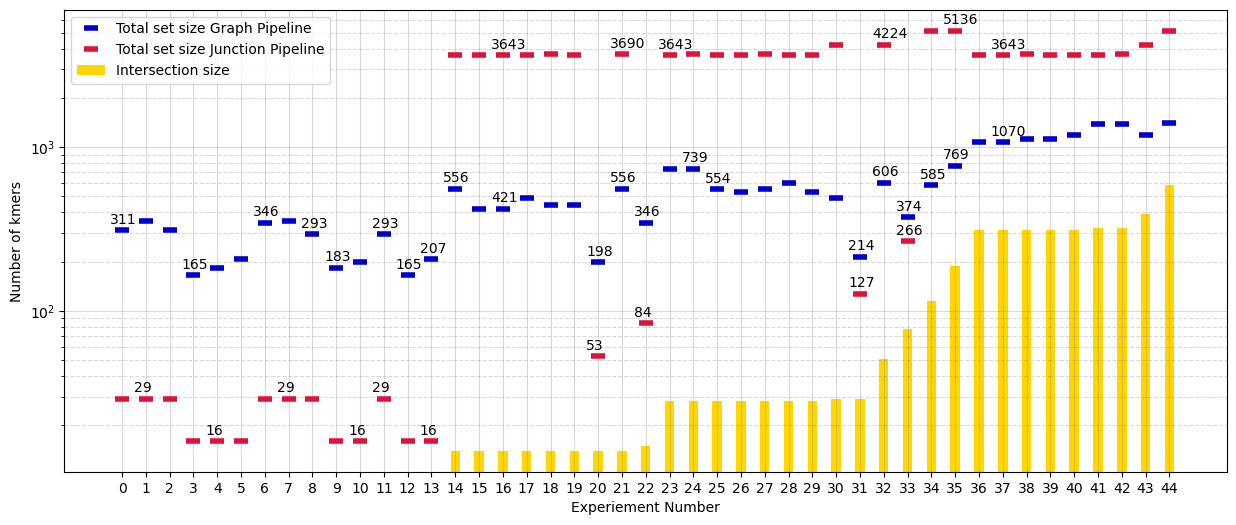

In [269]:
colorgrid = 'grey'
alpha_grid = 0.3
marker_size = 10
mew = 4
color1 = 'gold'
color2 = 'crimson'
color4 = 'mediumblue'
colorgrid = 'grey'

plt.figure(figsize=(15, 6))
plt.grid(b=True, axis = 'both', which='major', color=colorgrid, linestyle='-', alpha=alpha_grid)
plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)
width = 0.4
plt.bar(df['index'], df['size_intersection'], width=width, 
        color=color1, label='Intersection size')
plt.plot(df['index'], df['size_eth'], alpha=1, color=color4,
         linestyle = 'None', markerfacecolor='None', marker="_", markersize=marker_size, markeredgewidth=mew,
         label = 'Total set size Graph Pipeline')
plt.plot(df['index'], df['size_ohsu'], alpha=1, color=color2,
         linestyle = 'None', markerfacecolor='None', marker="_", markersize=marker_size, markeredgewidth=mew,
         label = 'Total set size Junction Pipeline')

plot_text(df['size_ohsu'], df['size_ohsu'])
plot_text(df['size_eth'], df['size_eth'])
#plot_text_all(df['index'], df['size_intersection'], df['size_intersection'])

plt.xticks(np.arange(len(df['index'])))
plt.legend()
plt.ylabel('Number of kmers')
plt.xlabel('Experiement Number')
plt.yscale('log')

# Plot Intersections

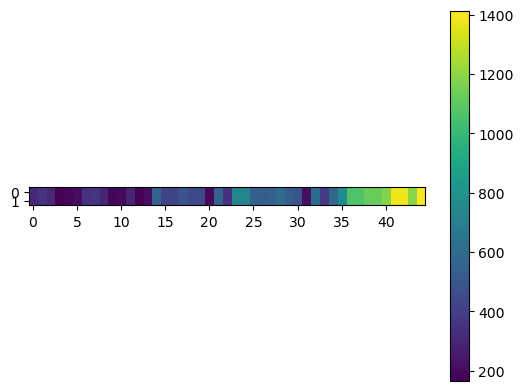

In [78]:
plt.imshow( [df['size_eth'],  df['size_eth']], cmap='viridis')
plt.colorbar()